# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Thu Feb 04 20:52:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    11W / 151W |    511MiB /  8192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019/'
dir_img = os.path.join(
    dir_base, 'train_images_300/rescaled_enhanced_green_rgb')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/'))

In [5]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
save_csv = 'log_training.csv'
save_EOE_train_head = 'EOE_classifier.h5'
save_best_train_head = 'best_classifier.h5'
save_EOE_train_body = 'EOE_fine_tune.h5'
save_best_train_body = 'best_fine_tune.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [6]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [7]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [8]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [9]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [10]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [11]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [12]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [13]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [14]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [15]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [16]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [17]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [18]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [19]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [20]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [21]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [22]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [23]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [24]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [25]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [26]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

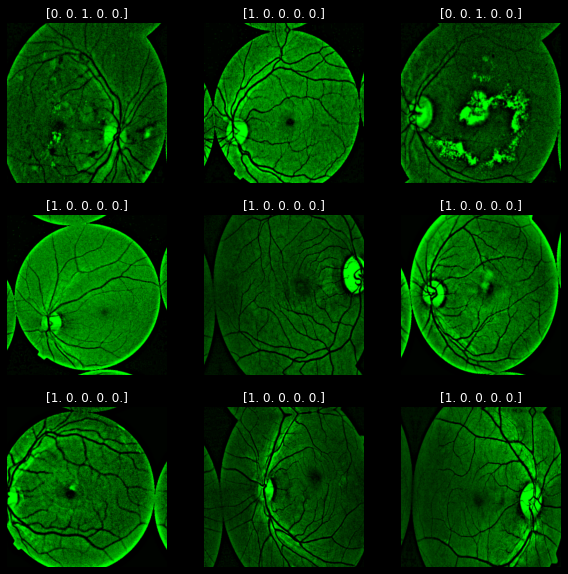

In [27]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [28]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [29]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [30]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [31]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [32]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

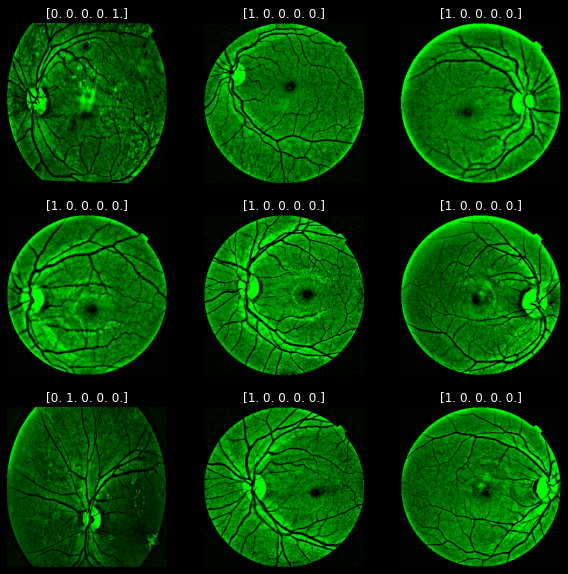

In [33]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [34]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [35]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [36]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))

In [37]:
conv_base, model = create_model()

In [38]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [39]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [40]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 2s - loss: 10.6860 - categorical_accuracy: 0.4758 - precision: 0.5561 - recall: 0.3854 - auc: 0.7677
Epoch 00001: val_loss improved from inf to 10.08512, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 207s 2s/step - loss: 10.6796 - categorical_accuracy: 0.4764 - precision: 0.5569 - recall: 0.3863 - auc: 0.7686 - val_loss: 10.0851 - val_categorical_accuracy: 0.4757 - val_precision: 0.5393 - val_recall: 0.2157 - val_auc: 0.7799
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1523 - categorical_accuracy: 0.5463 - precision: 0.6318 - recall: 0.4783 - auc: 0.8304
Epoch 00002: val_loss improved from 10.08512 to 9.60748, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.2817 - categorical_accuracy: 0.6775 - precision: 0.7439 - recall: 0.5987 - auc: 0.9156
Epoch 00015: val_loss improved from 6.33174 to 6.13633, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 6.2755 - categorical_accuracy: 0.6783 - precision: 0.7447 - recall: 0.5994 - auc: 0.9160 - val_loss: 6.1363 - val_categorical_accuracy: 0.7300 - val_precision: 0.8039 - val_recall: 0.6443 - val_auc: 0.9404
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 6.0059 - categorical_accuracy: 0.6887 - precision: 0.7611 - recall: 0.6139 - auc: 0.9224
Epoch 00016: val_loss improved from 6.13633 to 5.89081, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 6.0022 - categorical_accuracy: 0

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8513 - categorical_accuracy: 0.7115 - precision: 0.7858 - recall: 0.6381 - auc: 0.9350
Epoch 00029: val_loss improved from 3.95157 to 3.83268, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 136s 2s/step - loss: 3.8528 - categorical_accuracy: 0.7116 - precision: 0.7853 - recall: 0.6380 - auc: 0.9350 - val_loss: 3.8327 - val_categorical_accuracy: 0.7186 - val_precision: 0.7730 - val_recall: 0.6471 - val_auc: 0.9393
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 3.7018 - categorical_accuracy: 0.7119 - precision: 0.7863 - recall: 0.6369 - auc: 0.9362
Epoch 00030: val_loss improved from 3.83268 to 3.70714, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 3.7128 - categorical_accuracy: 0

Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.5751 - categorical_accuracy: 0.7252 - precision: 0.7980 - recall: 0.6457 - auc: 0.9395
Epoch 00043: val_loss improved from 2.69152 to 2.61907, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 2.5778 - categorical_accuracy: 0.7252 - precision: 0.7981 - recall: 0.6455 - auc: 0.9393 - val_loss: 2.6191 - val_categorical_accuracy: 0.7643 - val_precision: 0.8182 - val_recall: 0.6943 - val_auc: 0.9510
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.4834 - categorical_accuracy: 0.7220 - precision: 0.7947 - recall: 0.6396 - auc: 0.9427
Epoch 00044: val_loss improved from 2.61907 to 2.57809, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 2.4802 - categorical_accuracy: 0

In [41]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

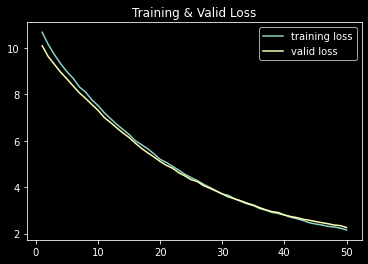

In [42]:
plot_loss(history)

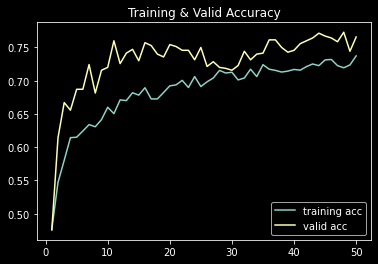

In [43]:
plot_acc(history)

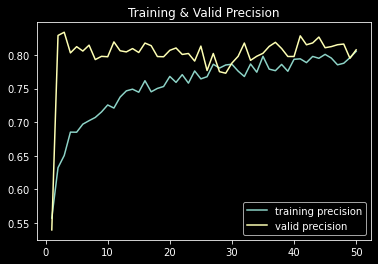

In [44]:
plot_precision(history)

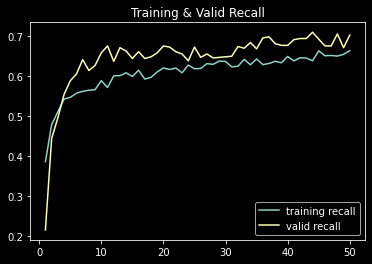

In [45]:
plot_recall(history)

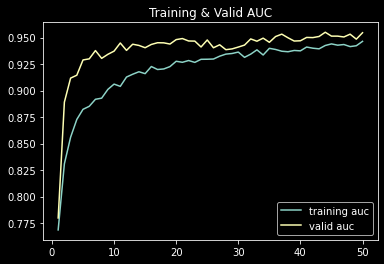

In [46]:
plot_auc(history)

### Evaluate model

In [47]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 589ms/step - loss: 1.9261 - categorical_accuracy: 0.7657 - precision: 0.8079 - recall: 0.7029 - auc: 0.9545


[1.9261407147754321, 0.7657143, 0.8078818, 0.70285714, 0.95453936]

In [48]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [49]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 536ms/step


In [50]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.97      0.97       359
         mild       0.51      0.58      0.55        67
     moderate       0.74      0.56      0.64       185
       severe       0.35      0.66      0.46        35
proliferative       0.38      0.37      0.38        54

     accuracy                           0.77       700
    macro avg       0.59      0.63      0.60       700
 weighted avg       0.78      0.77      0.77       700



In [51]:
confusion_matrix(y_true, y_pred)

array([[350,   7,   1,   1,   0],
       [  9,  39,  16,   0,   3],
       [  5,  28, 104,  25,  23],
       [  0,   0,   6,  23,   6],
       [  2,   2,  13,  17,  20]], dtype=int64)

## Fine Tune

In [52]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [53]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [54]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [55]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1291 - categorical_accuracy: 0.7437 - precision: 0.8072 - recall: 0.6735 - auc: 0.9463
Epoch 00001: val_loss improved from inf to 2.26813, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_fine_tune.h5
88/88 [==============================] - 151s 2s/step - loss: 2.1373 - categorical_accuracy: 0.7427 - precision: 0.8075 - recall: 0.6730 - auc: 0.9461 - val_loss: 2.2681 - val_categorical_accuracy: 0.7614 - val_precision: 0.8090 - val_recall: 0.6957 - val_auc: 0.9540
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0965 - categorical_accuracy: 0.7542 - precision: 0.8167 - recall: 0.6797 - auc: 0.9494
Epoch 00002: val_loss improved from 2.26813 to 2.26771, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_fine_tune.h5
88/88 [===

88/88 [==============================] - 139s 2s/step - loss: 2.0502 - categorical_accuracy: 0.7545 - precision: 0.8080 - recall: 0.6830 - auc: 0.9528 - val_loss: 2.2300 - val_categorical_accuracy: 0.7757 - val_precision: 0.8211 - val_recall: 0.7214 - val_auc: 0.9551
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0440 - categorical_accuracy: 0.7650 - precision: 0.8289 - recall: 0.6938 - auc: 0.9549
Epoch 00016: val_loss improved from 2.23004 to 2.22900, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold1\best_fine_tune.h5
88/88 [==============================] - 138s 2s/step - loss: 2.0441 - categorical_accuracy: 0.7652 - precision: 0.8293 - recall: 0.6944 - auc: 0.9550 - val_loss: 2.2290 - val_categorical_accuracy: 0.7757 - val_precision: 0.8182 - val_recall: 0.7200 - val_auc: 0.9554
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 2.0430 - categorical_accuracy: 0.7650 - precision: 0.8237 - recall: 0.6909 - 

87/88 [============================>.] - ETA: 1s - loss: 1.9766 - categorical_accuracy: 0.7755 - precision: 0.8335 - recall: 0.7111 - auc: 0.9583
Epoch 00031: val_loss did not improve from 2.20288
88/88 [==============================] - 134s 2s/step - loss: 1.9764 - categorical_accuracy: 0.7756 - precision: 0.8340 - recall: 0.7109 - auc: 0.9584 - val_loss: 2.2144 - val_categorical_accuracy: 0.7800 - val_precision: 0.8220 - val_recall: 0.7257 - val_auc: 0.9574
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 2.0021 - categorical_accuracy: 0.7737 - precision: 0.8284 - recall: 0.7104 - auc: 0.9575
Epoch 00032: val_loss did not improve from 2.20288
88/88 [==============================] - 134s 2s/step - loss: 1.9993 - categorical_accuracy: 0.7738 - precision: 0.8286 - recall: 0.7102 - auc: 0.9577 - val_loss: 2.2110 - val_categorical_accuracy: 0.7814 - val_precision: 0.8236 - val_recall: 0.7271 - val_auc: 0.9570
Epoch 33/50
87/88 [============================>.] - ETA: 

In [56]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

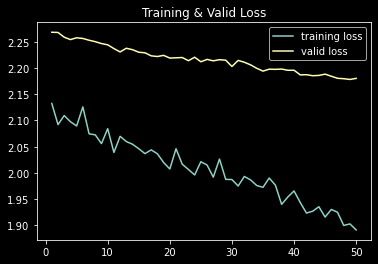

In [57]:
plot_loss(history)

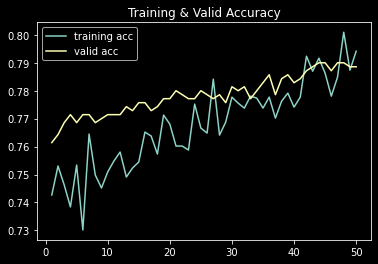

In [58]:
plot_acc(history)

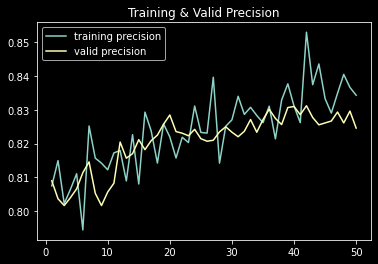

In [59]:
plot_precision(history)

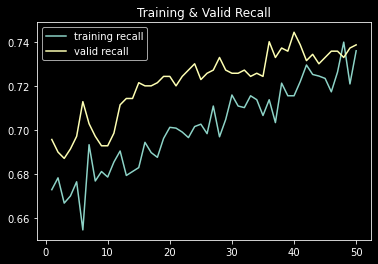

In [60]:
plot_recall(history)

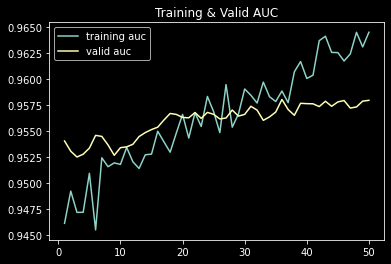

In [61]:
plot_auc(history)

### Evaluate model

In [62]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 609ms/step - loss: 1.8414 - categorical_accuracy: 0.7886 - precision: 0.8246 - recall: 0.7386 - auc: 0.9579


[1.8414299108765342, 0.7885714, 0.8245614, 0.7385714, 0.9579348]

In [63]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [64]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 598ms/step


In [65]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.97      0.97       359
         mild       0.54      0.66      0.59        67
     moderate       0.77      0.60      0.67       185
       severe       0.34      0.60      0.44        35
proliferative       0.49      0.48      0.49        54

     accuracy                           0.79       700
    macro avg       0.62      0.66      0.63       700
 weighted avg       0.81      0.79      0.79       700



In [66]:
confusion_matrix(y_true, y_pred)

array([[350,   9,   0,   0,   0],
       [  6,  44,  14,   0,   3],
       [  4,  25, 111,  27,  18],
       [  0,   1,   7,  21,   6],
       [  1,   2,  12,  13,  26]], dtype=int64)

# Fold 2

## Train classifier

In [67]:
del(model)

In [68]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [69]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [70]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))

In [71]:
conv_base, model = create_model()

In [72]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [73]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [74]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.6904 - categorical_accuracy: 0.4765 - precision: 0.5479 - recall: 0.3908 - auc: 0.7688
Epoch 00001: val_loss improved from inf to 10.22037, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 154s 2s/step - loss: 10.6870 - categorical_accuracy: 0.4768 - precision: 0.5473 - recall: 0.3906 - auc: 0.7690 - val_loss: 10.2204 - val_categorical_accuracy: 0.4557 - val_precision: 0.5084 - val_recall: 0.2157 - val_auc: 0.7515
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1328 - categorical_accuracy: 0.5611 - precision: 0.6302 - recall: 0.4830 - auc: 0.8317
Epoch 00002: val_loss improved from 10.22037 to 9.61979, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1197 - categorical_accuracy: 0.6829 - precision: 0.7599 - recall: 0.6168 - auc: 0.9243
Epoch 00015: val_loss improved from 6.25057 to 6.01259, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 6.1195 - categorical_accuracy: 0.6819 - precision: 0.7601 - recall: 0.6162 - auc: 0.9238 - val_loss: 6.0126 - val_categorical_accuracy: 0.7343 - val_precision: 0.7884 - val_recall: 0.6600 - val_auc: 0.9436
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.8998 - categorical_accuracy: 0.6967 - precision: 0.7674 - recall: 0.6095 - auc: 0.9253
Epoch 00016: val_loss improved from 6.01259 to 5.80535, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 5.8989 - categorical_accuracy: 0

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7190 - categorical_accuracy: 0.7072 - precision: 0.7799 - recall: 0.6381 - auc: 0.9366
Epoch 00029: val_loss improved from 3.83351 to 3.73048, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 3.7175 - categorical_accuracy: 0.7069 - precision: 0.7797 - recall: 0.6376 - auc: 0.9367 - val_loss: 3.7305 - val_categorical_accuracy: 0.7643 - val_precision: 0.8196 - val_recall: 0.6943 - val_auc: 0.9562
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 3.6136 - categorical_accuracy: 0.7133 - precision: 0.7923 - recall: 0.6385 - auc: 0.9375
Epoch 00030: val_loss improved from 3.73048 to 3.59546, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 3.6106 - categorical_accuracy: 0

Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4673 - categorical_accuracy: 0.7339 - precision: 0.8096 - recall: 0.6471 - auc: 0.9444
Epoch 00043: val_loss improved from 2.59560 to 2.53882, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 2.4627 - categorical_accuracy: 0.7352 - precision: 0.8107 - recall: 0.6476 - auc: 0.9447 - val_loss: 2.5388 - val_categorical_accuracy: 0.7457 - val_precision: 0.8038 - val_recall: 0.6671 - val_auc: 0.9481
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3796 - categorical_accuracy: 0.7350 - precision: 0.8026 - recall: 0.6645 - auc: 0.9453
Epoch 00044: val_loss improved from 2.53882 to 2.49846, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 2.3796 - categorical_accuracy: 0

In [75]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

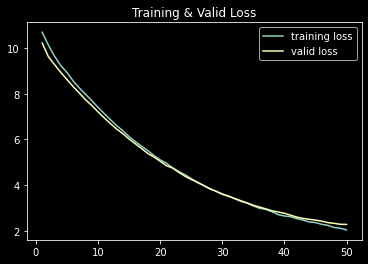

In [76]:
plot_loss(history)

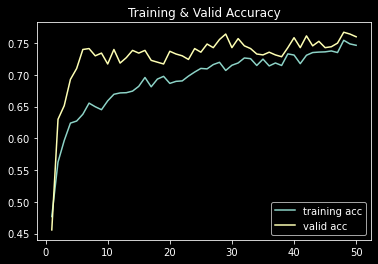

In [77]:
plot_acc(history)

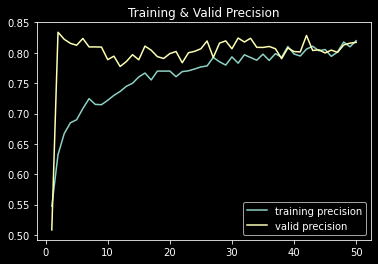

In [78]:
plot_precision(history)

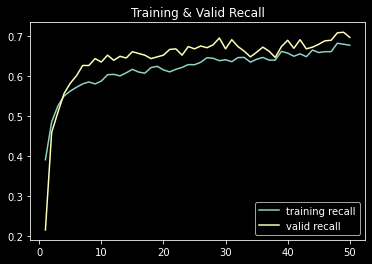

In [79]:
plot_recall(history)

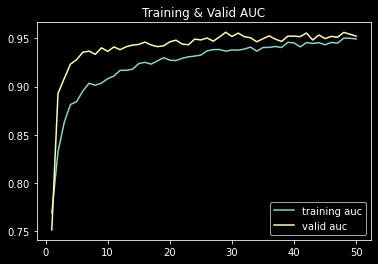

In [80]:
plot_auc(history)

### Evaluate model

In [81]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 611ms/step - loss: 1.8638 - categorical_accuracy: 0.7600 - precision: 0.8171 - recall: 0.6957 - auc: 0.9522


[1.8637652342969722, 0.76, 0.8171141, 0.6957143, 0.95220786]

In [82]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [83]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 556ms/step


In [84]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.48      0.51      0.50        68
     moderate       0.72      0.59      0.65       184
       severe       0.40      0.54      0.46        35
proliferative       0.36      0.43      0.39        54

     accuracy                           0.76       700
    macro avg       0.58      0.61      0.59       700
 weighted avg       0.77      0.76      0.76       700



In [85]:
confusion_matrix(y_true, y_pred)

array([[347,   7,   3,   0,   2],
       [ 10,  35,  20,   1,   2],
       [  8,  26, 108,  19,  23],
       [  1,   0,   1,  19,  14],
       [  0,   5,  17,   9,  23]], dtype=int64)

## Fine Tune

In [86]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [87]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [88]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [89]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0241 - categorical_accuracy: 0.7440 - precision: 0.8026 - recall: 0.6793 - auc: 0.9510
Epoch 00001: val_loss improved from inf to 2.27578, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_fine_tune.h5
88/88 [==============================] - 155s 2s/step - loss: 2.0244 - categorical_accuracy: 0.7452 - precision: 0.8041 - recall: 0.6805 - auc: 0.9514 - val_loss: 2.2758 - val_categorical_accuracy: 0.7643 - val_precision: 0.8230 - val_recall: 0.7043 - val_auc: 0.9532
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0299 - categorical_accuracy: 0.7542 - precision: 0.8081 - recall: 0.6804 - auc: 0.9511
Epoch 00002: val_loss improved from 2.27578 to 2.25575, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_fine_tune.h5
88/88 [===

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 1.9481 - categorical_accuracy: 0.7784 - precision: 0.8341 - recall: 0.7035 - auc: 0.9573
Epoch 00015: val_loss improved from 2.20354 to 2.20240, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_fine_tune.h5
88/88 [==============================] - 139s 2s/step - loss: 1.9502 - categorical_accuracy: 0.7781 - precision: 0.8332 - recall: 0.7034 - auc: 0.9573 - val_loss: 2.2024 - val_categorical_accuracy: 0.7543 - val_precision: 0.8046 - val_recall: 0.6943 - val_auc: 0.9544
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.9260 - categorical_accuracy: 0.7664 - precision: 0.8315 - recall: 0.7119 - auc: 0.9588
Epoch 00016: val_loss improved from 2.20240 to 2.20084, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold2\best_fine_tune.h5
88/88 [==============================] - 139s 2s/step - loss: 1.9228 - categorical_accuracy: 0.7

Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.8301 - categorical_accuracy: 0.7950 - precision: 0.8373 - recall: 0.7386 - auc: 0.9645
Epoch 00046: val_loss did not improve from 2.14285
88/88 [==============================] - 134s 2s/step - loss: 1.8264 - categorical_accuracy: 0.7963 - precision: 0.8387 - recall: 0.7395 - auc: 0.9648 - val_loss: 2.1488 - val_categorical_accuracy: 0.7686 - val_precision: 0.8146 - val_recall: 0.7343 - val_auc: 0.9601
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.7902 - categorical_accuracy: 0.8040 - precision: 0.8526 - recall: 0.7484 - auc: 0.9674
Epoch 00047: val_loss did not improve from 2.14285
88/88 [==============================] - 134s 2s/step - loss: 1.7888 - categorical_accuracy: 0.8049 - precision: 0.8531 - recall: 0.7491 - auc: 0.9675 - val_loss: 2.1577 - val_categorical_accuracy: 0.7771 - val_precision: 0.8145 - val_recall: 0.7400 - val_auc: 0.9605
Epoch 48/50
87/88 [===========================

In [90]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

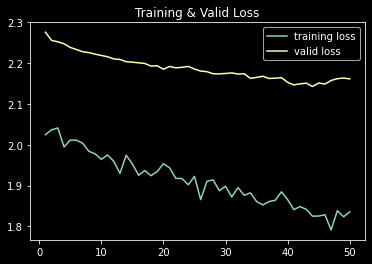

In [91]:
plot_loss(history)

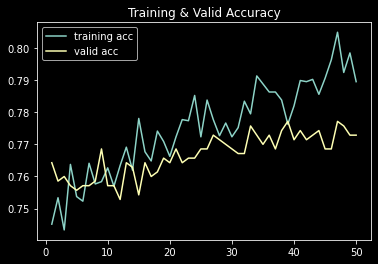

In [92]:
plot_acc(history)

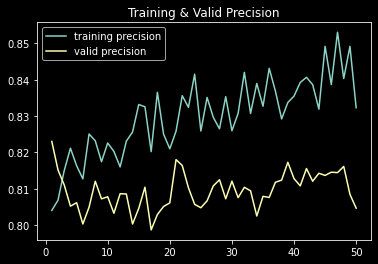

In [93]:
plot_precision(history)

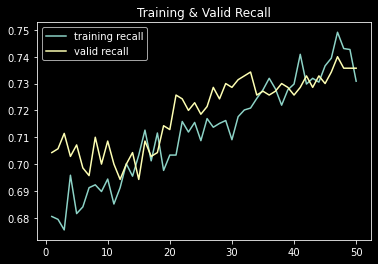

In [94]:
plot_recall(history)

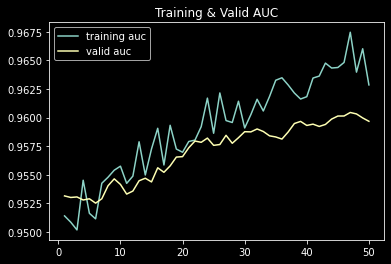

In [95]:
plot_auc(history)

### Evaluate model

In [96]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 615ms/step - loss: 1.7584 - categorical_accuracy: 0.7729 - precision: 0.8047 - recall: 0.7357 - auc: 0.9597


[1.758397021076896, 0.7728571, 0.8046875, 0.73571426, 0.9596806]

In [97]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [98]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 557ms/step


In [99]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       359
         mild       0.49      0.65      0.56        68
     moderate       0.74      0.57      0.64       184
       severe       0.38      0.57      0.45        35
proliferative       0.42      0.41      0.42        54

     accuracy                           0.77       700
    macro avg       0.60      0.63      0.61       700
 weighted avg       0.79      0.77      0.77       700



In [100]:
confusion_matrix(y_true, y_pred)

array([[351,   5,   2,   0,   1],
       [  6,  44,  18,   0,   0],
       [  6,  33, 104,  24,  17],
       [  1,   0,   2,  20,  12],
       [  1,   7,  15,   9,  22]], dtype=int64)

# Fold 3

## Train classifier

In [101]:
del(model)

In [102]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [103]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [104]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))

In [105]:
conv_base, model = create_model()

In [106]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [107]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [108]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7097 - categorical_accuracy: 0.4693 - precision: 0.5589 - recall: 0.3825 - auc: 0.7645
Epoch 00001: val_loss improved from inf to 10.14650, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 155s 2s/step - loss: 10.6970 - categorical_accuracy: 0.4703 - precision: 0.5597 - recall: 0.3835 - auc: 0.7657 - val_loss: 10.1465 - val_categorical_accuracy: 0.5843 - val_precision: 0.7915 - val_recall: 0.2929 - val_auc: 0.8507
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0860 - categorical_accuracy: 0.5615 - precision: 0.6345 - recall: 0.4783 - auc: 0.8364
Epoch 00002: val_loss improved from 10.14650 to 9.66299, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1529 - categorical_accuracy: 0.7003 - precision: 0.7645 - recall: 0.6186 - auc: 0.9250
Epoch 00015: val_loss improved from 6.33717 to 6.18343, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 6.1469 - categorical_accuracy: 0.7005 - precision: 0.7650 - recall: 0.6190 - auc: 0.9253 - val_loss: 6.1834 - val_categorical_accuracy: 0.7343 - val_precision: 0.8164 - val_recall: 0.6414 - val_auc: 0.9382
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.9259 - categorical_accuracy: 0.7003 - precision: 0.7704 - recall: 0.6294 - auc: 0.9289
Epoch 00016: val_loss improved from 6.18343 to 5.92390, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 5.9254 - categorical_accuracy: 0

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7713 - categorical_accuracy: 0.7039 - precision: 0.7865 - recall: 0.6381 - auc: 0.9370
Epoch 00029: val_loss improved from 3.96600 to 3.86067, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 3.7700 - categorical_accuracy: 0.7034 - precision: 0.7864 - recall: 0.6383 - auc: 0.9370 - val_loss: 3.8607 - val_categorical_accuracy: 0.7371 - val_precision: 0.8066 - val_recall: 0.6671 - val_auc: 0.9445
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 3.6321 - categorical_accuracy: 0.7173 - precision: 0.7894 - recall: 0.6479 - auc: 0.9408
Epoch 00030: val_loss improved from 3.86067 to 3.73266, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 3.6338 - categorical_accuracy: 0

Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4987 - categorical_accuracy: 0.7245 - precision: 0.7904 - recall: 0.6461 - auc: 0.9407
Epoch 00043: val_loss improved from 2.70479 to 2.68204, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 2.5066 - categorical_accuracy: 0.7230 - precision: 0.7892 - recall: 0.6447 - auc: 0.9402 - val_loss: 2.6820 - val_categorical_accuracy: 0.7400 - val_precision: 0.8120 - val_recall: 0.6786 - val_auc: 0.9442
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.4125 - categorical_accuracy: 0.7354 - precision: 0.7990 - recall: 0.6598 - auc: 0.9466
Epoch 00044: val_loss improved from 2.68204 to 2.59975, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 2.4160 - categorical_accuracy: 0

In [109]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

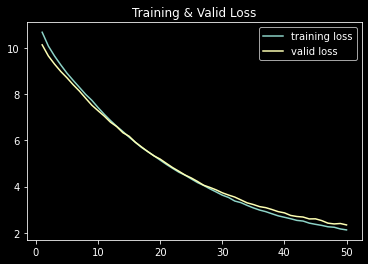

In [110]:
plot_loss(history)

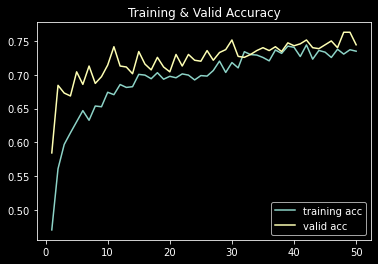

In [111]:
plot_acc(history)

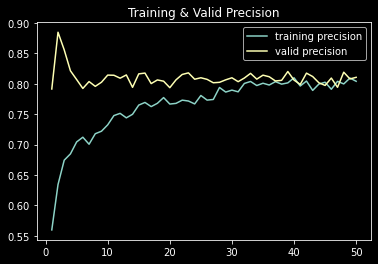

In [112]:
plot_precision(history)

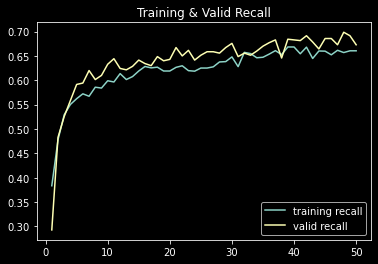

In [113]:
plot_recall(history)

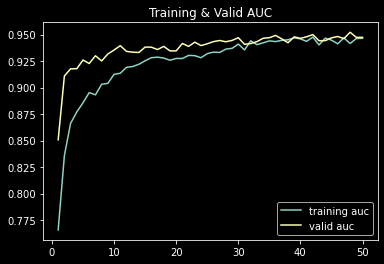

In [114]:
plot_auc(history)

### Evaluate model

In [115]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 615ms/step - loss: 1.9304 - categorical_accuracy: 0.7443 - precision: 0.8107 - recall: 0.6729 - auc: 0.9474


[1.930402473969893, 0.7442857, 0.81067127, 0.67285717, 0.9473778]

In [116]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [117]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 560ms/step


In [118]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.92      0.98      0.95       359
         mild       0.40      0.49      0.44        68
     moderate       0.71      0.48      0.58       184
       severe       0.33      0.46      0.38        35
proliferative       0.50      0.57      0.53        54

     accuracy                           0.74       700
    macro avg       0.57      0.60      0.58       700
 weighted avg       0.75      0.74      0.74       700



In [119]:
confusion_matrix(y_true, y_pred)

array([[352,   6,   1,   0,   0],
       [ 16,  33,  13,   1,   5],
       [ 12,  40,  89,  26,  17],
       [  0,   0,  10,  16,   9],
       [  1,   4,  12,   6,  31]], dtype=int64)

## Fine Tune

In [120]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [121]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [122]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [123]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0588 - categorical_accuracy: 0.7249 - precision: 0.7997 - recall: 0.6598 - auc: 0.9482
Epoch 00001: val_loss improved from inf to 2.31624, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_fine_tune.h5
88/88 [==============================] - 155s 2s/step - loss: 2.0591 - categorical_accuracy: 0.7255 - precision: 0.7997 - recall: 0.6608 - auc: 0.9485 - val_loss: 2.3162 - val_categorical_accuracy: 0.7457 - val_precision: 0.8102 - val_recall: 0.6829 - val_auc: 0.9491
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0524 - categorical_accuracy: 0.7502 - precision: 0.8190 - recall: 0.6725 - auc: 0.9494
Epoch 00002: val_loss improved from 2.31624 to 2.31218, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold3\best_fine_tune.h5
88/88 [===

87/88 [============================>.] - ETA: 1s - loss: 1.9347 - categorical_accuracy: 0.7697 - precision: 0.8281 - recall: 0.7054 - auc: 0.9597
Epoch 00032: val_loss did not improve from 2.24830
88/88 [==============================] - 135s 2s/step - loss: 1.9314 - categorical_accuracy: 0.7713 - precision: 0.8292 - recall: 0.7062 - auc: 0.9601 - val_loss: 2.2508 - val_categorical_accuracy: 0.7643 - val_precision: 0.8016 - val_recall: 0.7100 - val_auc: 0.9533
Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.9298 - categorical_accuracy: 0.7780 - precision: 0.8309 - recall: 0.7126 - auc: 0.9600
Epoch 00033: val_loss did not improve from 2.24830
88/88 [==============================] - 135s 2s/step - loss: 1.9343 - categorical_accuracy: 0.7770 - precision: 0.8306 - recall: 0.7112 - auc: 0.9598 - val_loss: 2.2587 - val_categorical_accuracy: 0.7729 - val_precision: 0.8029 - val_recall: 0.7214 - val_auc: 0.9538
Epoch 34/50
87/88 [============================>.] - ETA: 

Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.8391 - categorical_accuracy: 0.7974 - precision: 0.8540 - recall: 0.7331 - auc: 0.9654
Epoch 00049: val_loss did not improve from 2.24408
88/88 [==============================] - 137s 2s/step - loss: 1.8440 - categorical_accuracy: 0.7970 - precision: 0.8537 - recall: 0.7323 - auc: 0.9651 - val_loss: 2.2447 - val_categorical_accuracy: 0.7714 - val_precision: 0.8057 - val_recall: 0.7229 - val_auc: 0.9548
Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.8382 - categorical_accuracy: 0.7936 - precision: 0.8486 - recall: 0.7379 - auc: 0.9666
Epoch 00050: val_loss did not improve from 2.24408
88/88 [==============================] - 140s 2s/step - loss: 1.8352 - categorical_accuracy: 0.7934 - precision: 0.8486 - recall: 0.7373 - auc: 0.9666 - val_loss: 2.2476 - val_categorical_accuracy: 0.7686 - val_precision: 0.8070 - val_recall: 0.7286 - val_auc: 0.9556


In [124]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

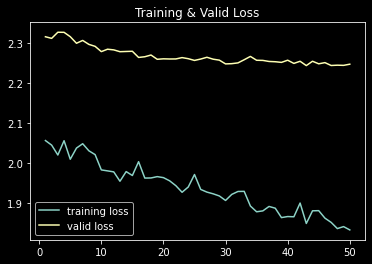

In [125]:
plot_loss(history)

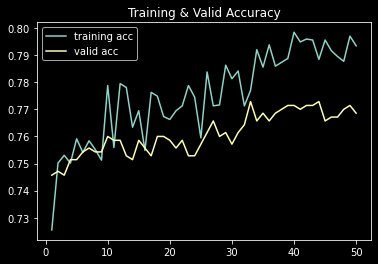

In [126]:
plot_acc(history)

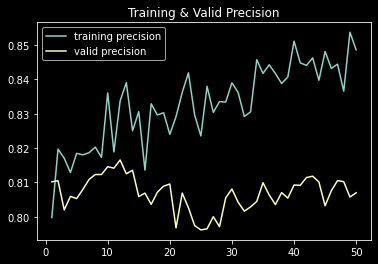

In [127]:
plot_precision(history)

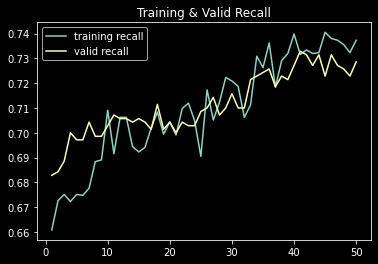

In [128]:
plot_recall(history)

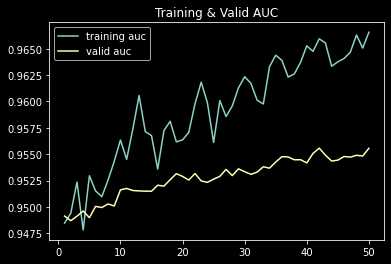

In [129]:
plot_auc(history)

### Evaluate model

In [130]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 654ms/step - loss: 1.8191 - categorical_accuracy: 0.7686 - precision: 0.8070 - recall: 0.7286 - auc: 0.9556


[1.8190524198792197, 0.76857144, 0.806962, 0.7285714, 0.9555579]

In [131]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [132]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 14s 621ms/step


In [133]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.98      0.96       359
         mild       0.48      0.54      0.51        68
     moderate       0.70      0.58      0.64       184
       severe       0.33      0.43      0.37        35
proliferative       0.53      0.52      0.52        54

     accuracy                           0.77       700
    macro avg       0.60      0.61      0.60       700
 weighted avg       0.77      0.77      0.77       700



In [134]:
confusion_matrix(y_true, y_pred)

array([[351,   7,   1,   0,   0],
       [ 10,  37,  17,   0,   4],
       [ 11,  29, 107,  24,  13],
       [  0,   0,  12,  15,   8],
       [  0,   4,  15,   7,  28]], dtype=int64)

# Fold 4

## Train classifier

In [135]:
del(model)

In [136]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [137]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [138]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))

In [139]:
conv_base, model = create_model()

In [140]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [141]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [142]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 3s - loss: 10.7771 - categorical_accuracy: 0.4561 - precision: 0.5339 - recall: 0.3726 - auc: 0.7534
Epoch 00001: val_loss improved from inf to 10.20915, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_classifier.h5
88/88 [==============================] - 325s 4s/step - loss: 10.7694 - categorical_accuracy: 0.4569 - precision: 0.5356 - recall: 0.3737 - auc: 0.7546 - val_loss: 10.2092 - val_categorical_accuracy: 0.4807 - val_precision: 0.5336 - val_recall: 0.1702 - val_auc: 0.7752
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1235 - categorical_accuracy: 0.5573 - precision: 0.6390 - recall: 0.4861 - auc: 0.8364
Epoch 00002: val_loss improved from 10.20915 to 9.68990, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_classifier.h5
88

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1972 - categorical_accuracy: 0.6751 - precision: 0.7464 - recall: 0.5923 - auc: 0.9205
Epoch 00015: val_loss improved from 6.28472 to 6.06239, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_classifier.h5
88/88 [==============================] - 136s 2s/step - loss: 6.1951 - categorical_accuracy: 0.6745 - precision: 0.7456 - recall: 0.5927 - auc: 0.9206 - val_loss: 6.0624 - val_categorical_accuracy: 0.7382 - val_precision: 0.8088 - val_recall: 0.6538 - val_auc: 0.9443
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.9973 - categorical_accuracy: 0.6784 - precision: 0.7499 - recall: 0.5992 - auc: 0.9184
Epoch 00016: val_loss improved from 6.06239 to 5.85945, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 6.0010 - categorical_accuracy: 0

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7527 - categorical_accuracy: 0.7156 - precision: 0.7889 - recall: 0.6321 - auc: 0.9372
Epoch 00029: val_loss improved from 3.94939 to 3.84561, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 3.7536 - categorical_accuracy: 0.7156 - precision: 0.7895 - recall: 0.6324 - auc: 0.9375 - val_loss: 3.8456 - val_categorical_accuracy: 0.7368 - val_precision: 0.7905 - val_recall: 0.6695 - val_auc: 0.9453
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 3.6378 - categorical_accuracy: 0.7181 - precision: 0.7885 - recall: 0.6361 - auc: 0.9398
Epoch 00030: val_loss improved from 3.84561 to 3.71354, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 3.6379 - categorical_accuracy: 0

In [143]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

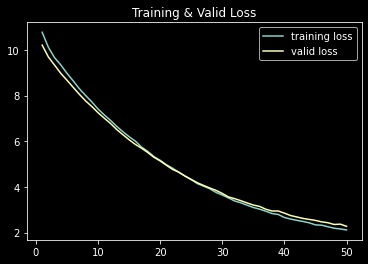

In [144]:
plot_loss(history)

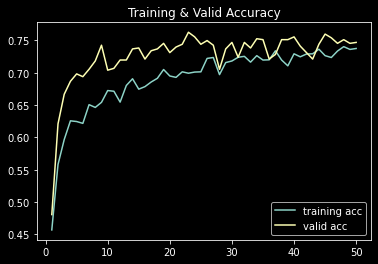

In [145]:
plot_acc(history)

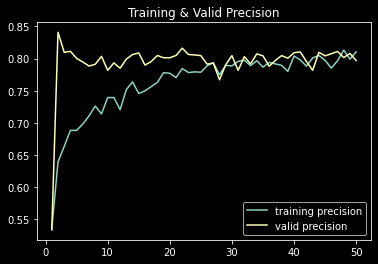

In [146]:
plot_precision(history)

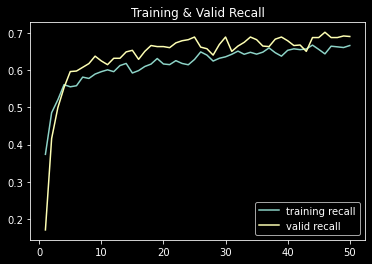

In [147]:
plot_recall(history)

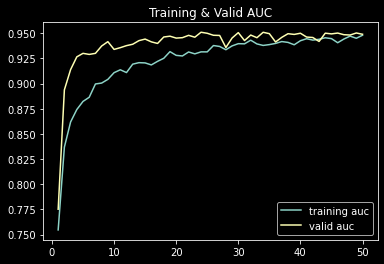

In [148]:
plot_auc(history)

### Evaluate model

In [149]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 599ms/step - loss: 1.8947 - categorical_accuracy: 0.7468 - precision: 0.7970 - recall: 0.6910 - auc: 0.9491


[1.894674767147411, 0.7467811, 0.7970297, 0.6909871, 0.9490638]

In [150]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [151]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 541ms/step


In [152]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.95      0.95       359
         mild       0.42      0.69      0.53        68
     moderate       0.72      0.55      0.62       184
       severe       0.31      0.47      0.37        34
proliferative       0.46      0.30      0.36        54

     accuracy                           0.75       699
    macro avg       0.57      0.59      0.57       699
 weighted avg       0.77      0.75      0.75       699



In [153]:
confusion_matrix(y_true, y_pred)

array([[342,  13,   1,   3,   0],
       [  8,  47,  12,   0,   1],
       [ 10,  44, 101,  18,  11],
       [  0,   2,   9,  16,   7],
       [  1,   5,  17,  15,  16]], dtype=int64)

## Fine Tune

In [154]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [155]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [156]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [157]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0555 - categorical_accuracy: 0.7261 - precision: 0.7923 - recall: 0.6632 - auc: 0.9465
Epoch 00001: val_loss improved from inf to 2.26957, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_fine_tune.h5
88/88 [==============================] - 151s 2s/step - loss: 2.0571 - categorical_accuracy: 0.7253 - precision: 0.7925 - recall: 0.6617 - auc: 0.9462 - val_loss: 2.2696 - val_categorical_accuracy: 0.7496 - val_precision: 0.7990 - val_recall: 0.6938 - val_auc: 0.9505
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0171 - categorical_accuracy: 0.7542 - precision: 0.8227 - recall: 0.6874 - auc: 0.9513
Epoch 00002: val_loss did not improve from 2.26957
88/88 [==============================] - 134s 2s/step - loss: 2.0141 - categorical_accuracy: 0.7542 - precision: 0.8222

Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 1.9539 - categorical_accuracy: 0.7806 - precision: 0.8364 - recall: 0.7076 - auc: 0.9592
Epoch 00016: val_loss improved from 2.22090 to 2.20630, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold4\best_fine_tune.h5
88/88 [==============================] - 138s 2s/step - loss: 1.9498 - categorical_accuracy: 0.7814 - precision: 0.8370 - recall: 0.7081 - auc: 0.9595 - val_loss: 2.2063 - val_categorical_accuracy: 0.7611 - val_precision: 0.8045 - val_recall: 0.7124 - val_auc: 0.9530
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 1.9486 - categorical_accuracy: 0.7727 - precision: 0.8312 - recall: 0.6993 - auc: 0.9575
Epoch 00017: val_loss did not improve from 2.20630
88/88 [==============================] - 134s 2s/step - loss: 1.9516 - categorical_accuracy: 0.7721 - precision: 0.8303 - recall: 0.6992 - auc: 0.9575 - val_loss: 2.2080 - val_categorical_accuracy: 0.7582 

87/88 [============================>.] - ETA: 1s - loss: 1.8133 - categorical_accuracy: 0.8081 - precision: 0.8517 - recall: 0.7535 - auc: 0.9672
Epoch 00048: val_loss did not improve from 2.17097
88/88 [==============================] - 135s 2s/step - loss: 1.8140 - categorical_accuracy: 0.8078 - precision: 0.8515 - recall: 0.7538 - auc: 0.9670 - val_loss: 2.1772 - val_categorical_accuracy: 0.7754 - val_precision: 0.8161 - val_recall: 0.7239 - val_auc: 0.9549
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.8430 - categorical_accuracy: 0.7911 - precision: 0.8345 - recall: 0.7289 - auc: 0.9642
Epoch 00049: val_loss did not improve from 2.17097
88/88 [==============================] - 134s 2s/step - loss: 1.8456 - categorical_accuracy: 0.7906 - precision: 0.8340 - recall: 0.7288 - auc: 0.9641 - val_loss: 2.1765 - val_categorical_accuracy: 0.7768 - val_precision: 0.8207 - val_recall: 0.7268 - val_auc: 0.9546
Epoch 50/50
87/88 [============================>.] - ETA: 

In [158]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

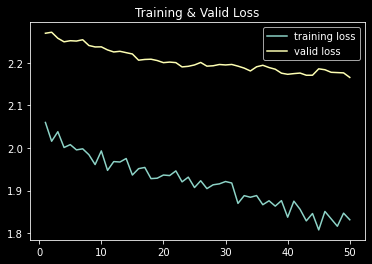

In [159]:
plot_loss(history)

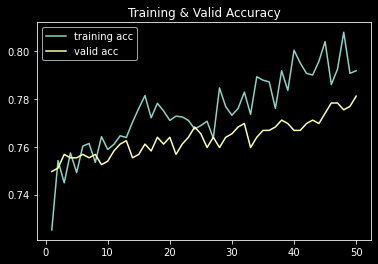

In [160]:
plot_acc(history)

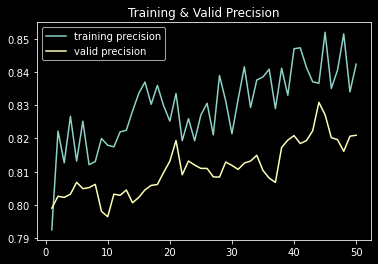

In [161]:
plot_precision(history)

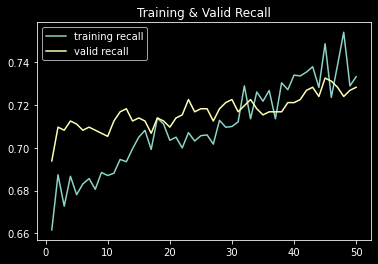

In [162]:
plot_recall(history)

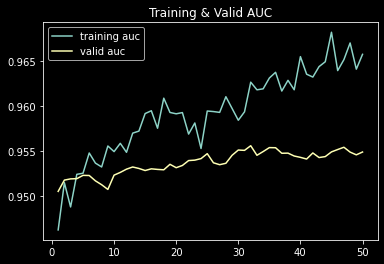

In [163]:
plot_auc(history)

### Evaluate model

In [164]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 604ms/step - loss: 1.8004 - categorical_accuracy: 0.7811 - precision: 0.8210 - recall: 0.7282 - auc: 0.9549


[1.8004283417354932, 0.7811159, 0.82096773, 0.7281831, 0.9548872]

In [165]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [166]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 16s 710ms/step


In [167]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       359
         mild       0.48      0.72      0.57        68
     moderate       0.76      0.59      0.66       184
       severe       0.36      0.50      0.42        34
proliferative       0.54      0.48      0.51        54

     accuracy                           0.78       699
    macro avg       0.62      0.65      0.63       699
 weighted avg       0.80      0.78      0.78       699



In [168]:
confusion_matrix(y_true, y_pred)

array([[346,  12,   0,   0,   1],
       [  6,  49,  11,   0,   2],
       [  7,  38, 108,  20,  11],
       [  0,   1,   8,  17,   8],
       [  0,   3,  15,  10,  26]], dtype=int64)

# Fold 5

## Train classifier

In [169]:
del(model)

In [170]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [171]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [172]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_enhanced_green_rgb/fold'+str(fold))

In [173]:
conv_base, model = create_model()

In [174]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [175]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [176]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7081 - categorical_accuracy: 0.4687 - precision: 0.5496 - recall: 0.3842 - auc: 0.7632
Epoch 00001: val_loss improved from inf to 10.10452, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 150s 2s/step - loss: 10.6979 - categorical_accuracy: 0.4698 - precision: 0.5518 - recall: 0.3862 - auc: 0.7643 - val_loss: 10.1045 - val_categorical_accuracy: 0.6481 - val_precision: 0.8370 - val_recall: 0.3233 - val_auc: 0.8833
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.0485 - categorical_accuracy: 0.5638 - precision: 0.6324 - recall: 0.4937 - auc: 0.8438
Epoch 00002: val_loss improved from 10.10452 to 9.64633, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 6.1317 - categorical_accuracy: 0.6957 - precision: 0.7553 - recall: 0.6169 - auc: 0.9259
Epoch 00015: val_loss improved from 6.34322 to 6.12531, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 139s 2s/step - loss: 6.1285 - categorical_accuracy: 0.6967 - precision: 0.7562 - recall: 0.6163 - auc: 0.9262 - val_loss: 6.1253 - val_categorical_accuracy: 0.7296 - val_precision: 0.8028 - val_recall: 0.6524 - val_auc: 0.9403
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 5.9226 - categorical_accuracy: 0.6765 - precision: 0.7422 - recall: 0.6057 - auc: 0.9208
Epoch 00016: val_loss improved from 6.12531 to 5.90070, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 5.9266 - categorical_accuracy: 0

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7094 - categorical_accuracy: 0.7221 - precision: 0.7919 - recall: 0.6545 - auc: 0.9405
Epoch 00029: val_loss improved from 4.00041 to 3.87944, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 3.7130 - categorical_accuracy: 0.7213 - precision: 0.7916 - recall: 0.6542 - auc: 0.9402 - val_loss: 3.8794 - val_categorical_accuracy: 0.7368 - val_precision: 0.7979 - val_recall: 0.6667 - val_auc: 0.9417
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 3.6488 - categorical_accuracy: 0.6939 - precision: 0.7636 - recall: 0.6245 - auc: 0.9320
Epoch 00030: val_loss improved from 3.87944 to 3.74749, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 3.6500 - categorical_accuracy: 0

Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4461 - categorical_accuracy: 0.7304 - precision: 0.7937 - recall: 0.6646 - auc: 0.9465
Epoch 00043: val_loss improved from 2.79928 to 2.69634, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 137s 2s/step - loss: 2.4487 - categorical_accuracy: 0.7306 - precision: 0.7934 - recall: 0.6642 - auc: 0.9464 - val_loss: 2.6963 - val_categorical_accuracy: 0.7210 - val_precision: 0.8098 - val_recall: 0.6638 - val_auc: 0.9414
Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.3801 - categorical_accuracy: 0.7308 - precision: 0.7835 - recall: 0.6578 - auc: 0.9444
Epoch 00044: val_loss improved from 2.69634 to 2.64201, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_classifier.h5
88/88 [==============================] - 138s 2s/step - loss: 2.3807 - categorical_accuracy: 0

In [177]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

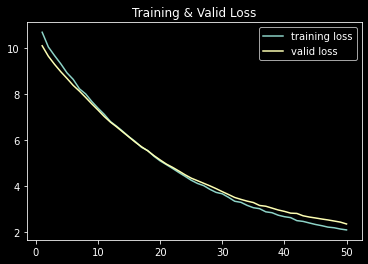

In [178]:
plot_loss(history)

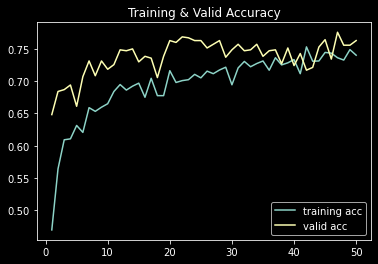

In [179]:
plot_acc(history)

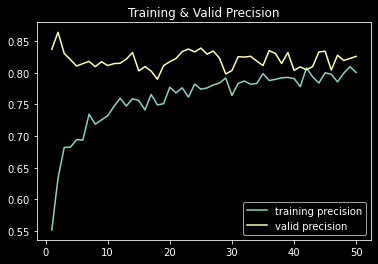

In [180]:
plot_precision(history)

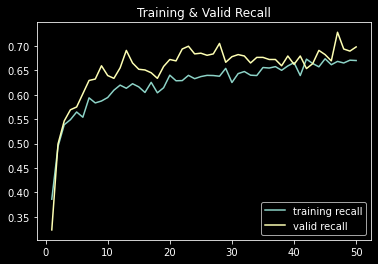

In [181]:
plot_recall(history)

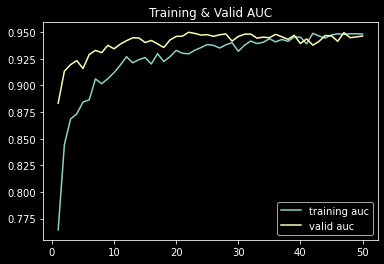

In [182]:
plot_auc(history)

### Evaluate model

In [183]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 602ms/step - loss: 1.9086 - categorical_accuracy: 0.7625 - precision: 0.8257 - recall: 0.6981 - auc: 0.9465


[1.9086123542352156, 0.76251787, 0.8257191, 0.6981402, 0.9464758]

In [184]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [185]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 543ms/step


In [186]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.93      0.97      0.95       360
         mild       0.40      0.51      0.44        67
     moderate       0.78      0.57      0.65       184
       severe       0.31      0.47      0.37        34
proliferative       0.57      0.52      0.54        54

     accuracy                           0.76       699
    macro avg       0.60      0.61      0.59       699
 weighted avg       0.78      0.76      0.76       699



In [187]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   1,   0,   2],
       [ 15,  34,  15,   0,   3],
       [  8,  35, 104,  25,  12],
       [  3,   2,   9,  16,   4],
       [  1,   9,   5,  11,  28]], dtype=int64)

## Fine Tune

In [188]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [189]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [190]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [191]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0091 - categorical_accuracy: 0.7412 - precision: 0.8026 - recall: 0.6787 - auc: 0.9522
Epoch 00001: val_loss improved from inf to 2.35726, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_fine_tune.h5
88/88 [==============================] - 152s 2s/step - loss: 2.0123 - categorical_accuracy: 0.7406 - precision: 0.8025 - recall: 0.6781 - auc: 0.9521 - val_loss: 2.3573 - val_categorical_accuracy: 0.7525 - val_precision: 0.8268 - val_recall: 0.6967 - val_auc: 0.9461
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 1.9912 - categorical_accuracy: 0.7557 - precision: 0.8152 - recall: 0.6823 - auc: 0.9539
Epoch 00002: val_loss improved from 2.35726 to 2.35620, saving model to D:/Datasets/thesis_dr/aptos2019/models/kfold_enhanced_green_rgb/fold5\best_fine_tune.h5
88/88 [===

Epoch 33/50
87/88 [============================>.] - ETA: 1s - loss: 1.8415 - categorical_accuracy: 0.7814 - precision: 0.8388 - recall: 0.7243 - auc: 0.9639
Epoch 00033: val_loss did not improve from 2.30976
88/88 [==============================] - 135s 2s/step - loss: 1.8388 - categorical_accuracy: 0.7817 - precision: 0.8387 - recall: 0.7245 - auc: 0.9641 - val_loss: 2.3309 - val_categorical_accuracy: 0.7754 - val_precision: 0.8252 - val_recall: 0.7225 - val_auc: 0.9515
Epoch 34/50
87/88 [============================>.] - ETA: 1s - loss: 1.8560 - categorical_accuracy: 0.7839 - precision: 0.8368 - recall: 0.7246 - auc: 0.9641
Epoch 00034: val_loss did not improve from 2.30976
88/88 [==============================] - 135s 2s/step - loss: 1.8563 - categorical_accuracy: 0.7846 - precision: 0.8371 - recall: 0.7253 - auc: 0.9641 - val_loss: 2.3168 - val_categorical_accuracy: 0.7740 - val_precision: 0.8276 - val_recall: 0.7282 - val_auc: 0.9517
Epoch 35/50
87/88 [===========================

Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.8103 - categorical_accuracy: 0.8034 - precision: 0.8475 - recall: 0.7492 - auc: 0.9686
Epoch 00050: val_loss did not improve from 2.30651
88/88 [==============================] - 135s 2s/step - loss: 1.8095 - categorical_accuracy: 0.8035 - precision: 0.8481 - recall: 0.7499 - auc: 0.9687 - val_loss: 2.3497 - val_categorical_accuracy: 0.7797 - val_precision: 0.8285 - val_recall: 0.7396 - val_auc: 0.9515


In [192]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

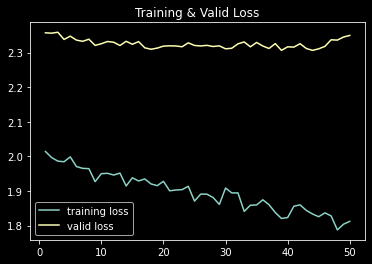

In [193]:
plot_loss(history)

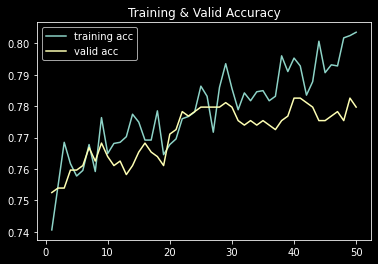

In [194]:
plot_acc(history)

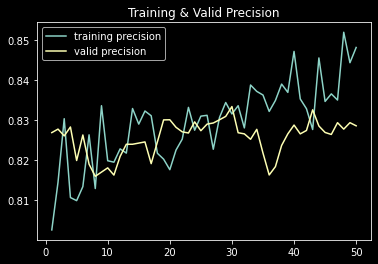

In [195]:
plot_precision(history)

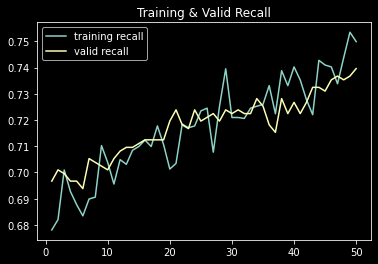

In [196]:
plot_recall(history)

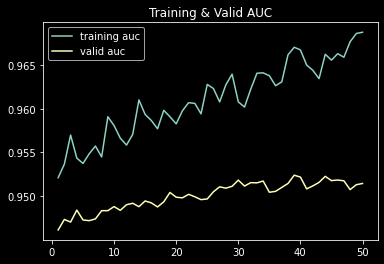

In [197]:
plot_auc(history)

### Evaluate model

In [198]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 613ms/step - loss: 1.8178 - categorical_accuracy: 0.7797 - precision: 0.8285 - recall: 0.7396 - auc: 0.9515


[1.8178180076859214, 0.77968526, 0.82852566, 0.739628, 0.9514505]

In [199]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [200]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 550ms/step


In [201]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.92      0.97      0.95       360
         mild       0.41      0.46      0.43        67
     moderate       0.74      0.66      0.70       184
       severe       0.39      0.38      0.39        34
proliferative       0.63      0.54      0.58        54

     accuracy                           0.78       699
    macro avg       0.62      0.60      0.61       699
 weighted avg       0.78      0.78      0.78       699



In [202]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   2,   0,   1],
       [ 18,  31,  16,   0,   2],
       [  8,  32, 121,  14,   9],
       [  3,   2,  11,  13,   5],
       [  1,   5,  13,   6,  29]], dtype=int64)